# Прогноз проницаемости образцов горной породы по петрофизическим свойствам методами машинного обучения

Необходимо разработать методику для прогноза проницаемости образцов горной породы по их петрофизическим свойствам методами машинного обучения.
Входными признаками являются: 
<ol>
<li>Общая пористость образца ($\Phi$) - это доля объёма порового пространства в общем объёме горного образца.
<li>Профиль пористости образца вдоль оси Z ($\phi_z$) - локальная пористость горного образца замеренная вдоль оси Z, она показывает степень однородности породы по направлению оси Z.
</ol>

Целевая функция:

Абсолютная проницаемость вдоль оси Z ($k_z$)- это величина, характеризующая способность горного образца пропускать жидкость (или газ) при перепаде давления, типичная размерность мД (миллидарси). Чем это значение выше, тем лучше образец пропускает жидкость.

## Загрузка обучающей выборки и визуализация данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Загрузка общей пористости образцов ($\Phi$, porosity):

In [2]:
porosity = pd.read_csv('porosity.csv', header=None, comment='#')
porosity.columns = ['Phi']
porosity.head()

,Phi
0,0.272959
1,0.282950
2,0.257120
3,0.131701
4,0.268803


Загрузка профиля пористости образца вдоль оси Z ($\phi_z$, porosityProfile):

In [3]:
porosityProfile=pd.read_csv('porosityProfile.csv', header=None, comment='#')
porosityProfile.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.349700,0.346050,0.339650,0.329400,0.321350,0.312875,0.304200,0.293325,0.284575,0.277875,...,0.265425,0.264750,0.270800,0.280625,0.289000,0.299825,0.311050,0.319000,0.325075,0.327650
1,0.304475,0.301300,0.294600,0.284950,0.274875,0.264375,0.252425,0.242700,0.235700,0.230900,...,0.302925,0.303025,0.302800,0.303750,0.313325,0.328175,0.347475,0.360550,0.368600,0.372650
2,0.314900,0.310725,0.302950,0.292325,0.282425,0.274525,0.269250,0.269750,0.274625,0.280725,...,0.203525,0.204700,0.208600,0.217125,0.229925,0.243775,0.255325,0.267675,0.275575,0.278975
3,0.221100,0.218525,0.213625,0.206600,0.198025,0.192325,0.185375,0.180975,0.177525,0.172250,...,0.140250,0.146750,0.155625,0.165800,0.177525,0.191400,0.206875,0.218350,0.226800,0.230650
4,0.308975,0.307525,0.304575,0.302425,0.297375,0.291900,0.285800,0.281175,0.281250,0.280300,...,0.247025,0.251775,0.260975,0.270600,0.278725,0.285150,0.288650,0.293175,0.297700,0.300425


Загрузка абсолютной проницаемости вдоль оси Z ($k_z$, permeabilityZ):

In [4]:
permeabilityZ = pd.read_csv('permeabilityZ.csv', header=None, comment='#')
permeabilityZ.columns = ['k_z']
permeabilityZ.head()

,k_z
0,2749.055177
1,2676.668810
2,2194.516422
3,28.551543
4,3170.427731


Гипотеза: общая пористость = среднему локальной пористости по всем слоям

Посчитаем среднуюю локальную пористость и добавим в нашу таблицу:

In [5]:
data = pd.DataFrame()
data['Phi'] = porosity.Phi
data['mean_fi_z'] = porosityProfile.mean()
data['k_z'] = permeabilityZ.k_z
data.head()

,Phi,mean_fi_z,k_z
0,0.272959,0.264607,2749.055177
1,0.282950,0.260592,2676.668810
2,0.257120,0.253075,2194.516422
3,0.131701,0.242714,28.551543
4,0.268803,0.230353,3170.427731


D:\Programs\Anaconda\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


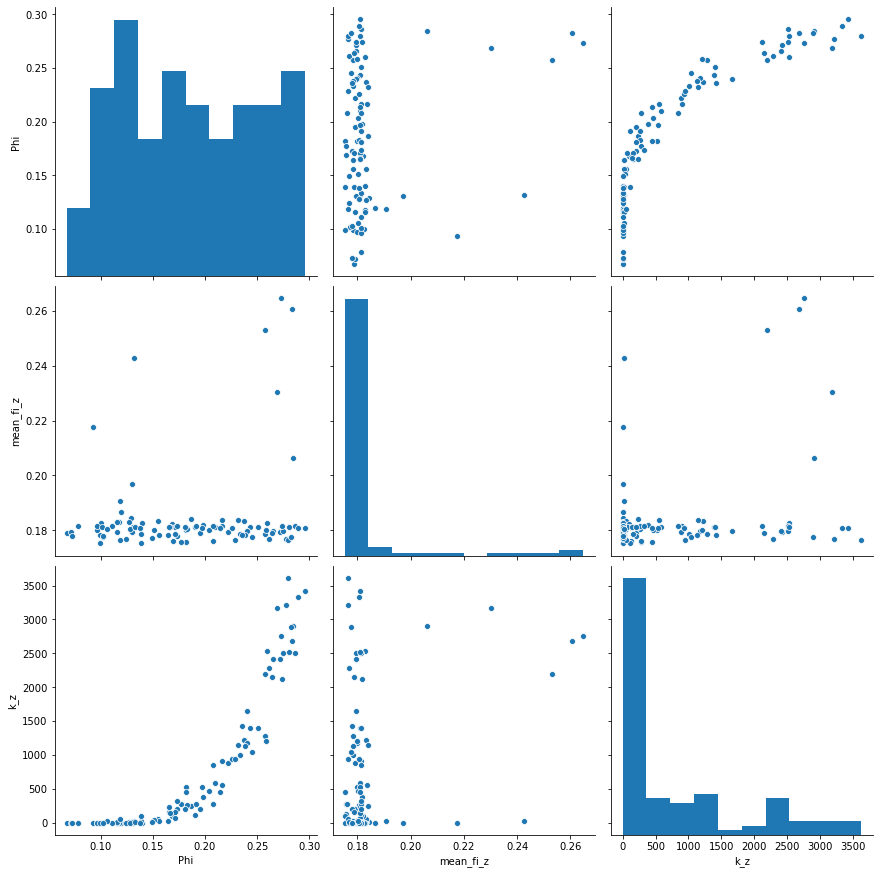

In [6]:
sns.pairplot(data, size=4)

Как мы видим, зависимость $\Phi$ от $k_z$ экспоненцильная, зависимость средного профиля пористости от полной пористости не просматривается, посмотрим на профили поподробнее

In [7]:
porosityProfile = porosityProfile.to_numpy()

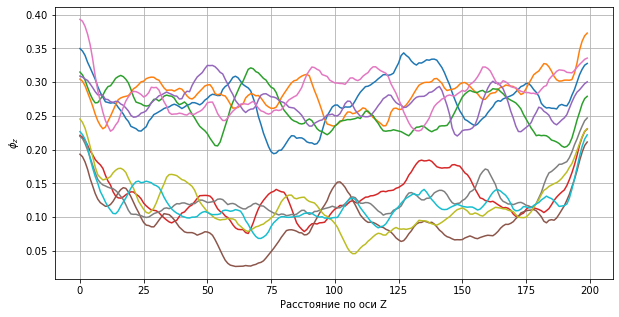

In [8]:
Z = np.arange(len(porosityProfile[0]))
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(Z,porosityProfile[i])
plt.grid()
plt.xlabel('Расстояние по оси Z')
plt.ylabel('$\phi_z$')
plt.show()

По краям каждого образтца мы видим завышение локальной пористости, возмжожно это связно с процедурой подготовки образца.
Пока оставим только зачения с 25 по 175 измерение.

In [9]:
cut_por_profile = porosityProfile[:, 25:175]

Посмотрим снова на зависимости наших величин уже с новым профилем

In [10]:
data['cut_mean_fi_z'] = cut_por_profile.mean(axis=1)

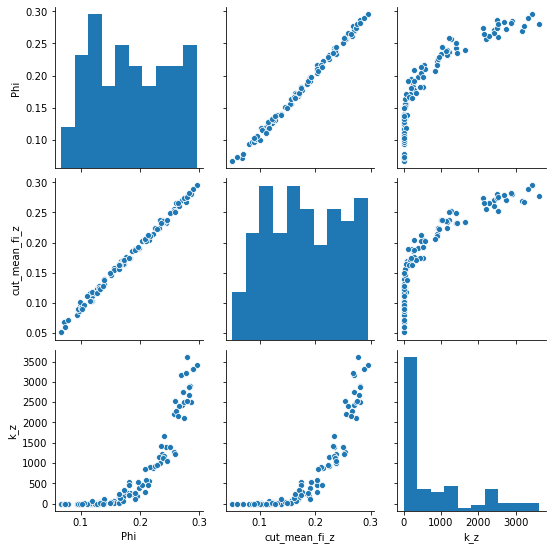

In [11]:
sns.pairplot(data[['Phi', 'cut_mean_fi_z', 'k_z']])

Отлично, у нас получилась линейная зависимость среднего от профиля проницаемости и общей проницаемости (как и должно быть). Теперь надо разобраться с пропускаемостью обрзаца

Немного теории:

У нас есть уравнение Пузеля:
\begin{equation}
\mathrm{Q}=\mathrm{F} \frac{\mathrm{mr}^{2} \Delta \mathrm{P}}{8 \mu \mathrm{L}}
\end{equation}
и уравнение Дарси:
\begin{equation}
\mathrm{Q}=\mathrm{Fk} \frac{\Delta \mathrm{P}}{\mathrm{L} \mu}
\end{equation}

Оба описывают объёмную скорость течения жидкости через такую пористую среду, приравняв части уравнения, мы получаем:
\begin{equation}
k_{n p}=\frac{m \cdot r^{2}}{8}
\end{equation}
где $k_{n p}$ -- проницаемость,
$m$ -пористость, $r^2$ -- радиус каналов.

Однако эти уравнения справедливы только для идельной среды, радиусы пор мы не знаем, да и не знаем, являются ли поры соединенными или изолированными. Поэтому пока из теории мы не можем достать что-то полезное

Зависимость $\Phi$ от $k_z$ экспоненцильная, неплохо бы прологарифмировать $k_z$, однако у нас есть нулевые значения $k_z$.

In [113]:
data[data.k_z == 0].count()

Phi              20
mean_fi_z        20
k_z              20
cut_mean_fi_z    20
transf_k_z        0
min_fi_z         20
std_fi_z         20
dtype: int64

В 20 процентах случаях у на $k_z$ = 0

А если мы пролагорифмируем значения, не равные нулю:

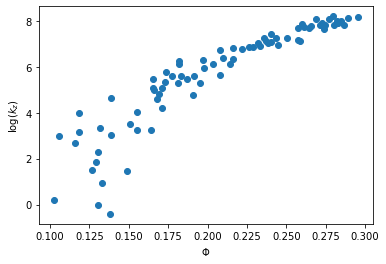

In [15]:
plt.scatter(data[data.k_z != 0].Phi, np.log(data[data.k_z != 0].k_z))
plt.xlabel('$\Phi$')
plt.ylabel('$\log (k_z)$')
plt.show()

Уже лучше, однако у нас до сих пор большая дисперсия при малых значениях , можно попробовать преобразование бокса кокса.

In [16]:
transf_k_x, lmbda = stats.boxcox(data[data.k_z != 0].k_z)

In [17]:
lmbda

0.23853311049164996

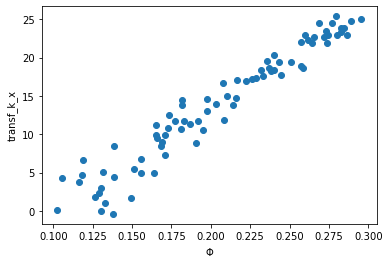

In [19]:
plt.scatter(data[data.k_z != 0].Phi, transf_k_x)
plt.xlabel('$\Phi$')
plt.ylabel('transf_k_x')
plt.show()

Вот так гораздо лучше, зависимость похожа на линейную, можно попробовать линейную регрессию, так как в выборке слишком мало объектов, и более сложные модели могу легко переобучиться

In [21]:
data.loc[data.k_z != 0, 'transf_k_z'] = transf_k_x

In [22]:
data.head()

,Phi,mean_fi_z,k_z,cut_mean_fi_z,transf_k_z
0,0.272959,0.264607,2749.055177,0.270675,23.528810
1,0.282950,0.260592,2676.668810,0.278904,23.352923
2,0.257120,0.253075,2194.516422,0.256409,22.078387
3,0.131701,0.242714,28.551543,0.124651,5.133104
4,0.268803,0.230353,3170.427731,0.269372,24.488021


Для предсказания ответа нам придется потом сделять обратное преобразование бокса кокса, сделать мы это сможем с помощью следующей функции

In [26]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Предположим, что вода проходит через породу по принципу "узкого горлыжка" и найдем для каждой породы минимальное значение пористости

In [27]:
min_fi_z = cut_por_profile.min(axis=1)
min_fi_z.shape

(100,)

In [28]:
data['min_fi_z'] = min_fi_z

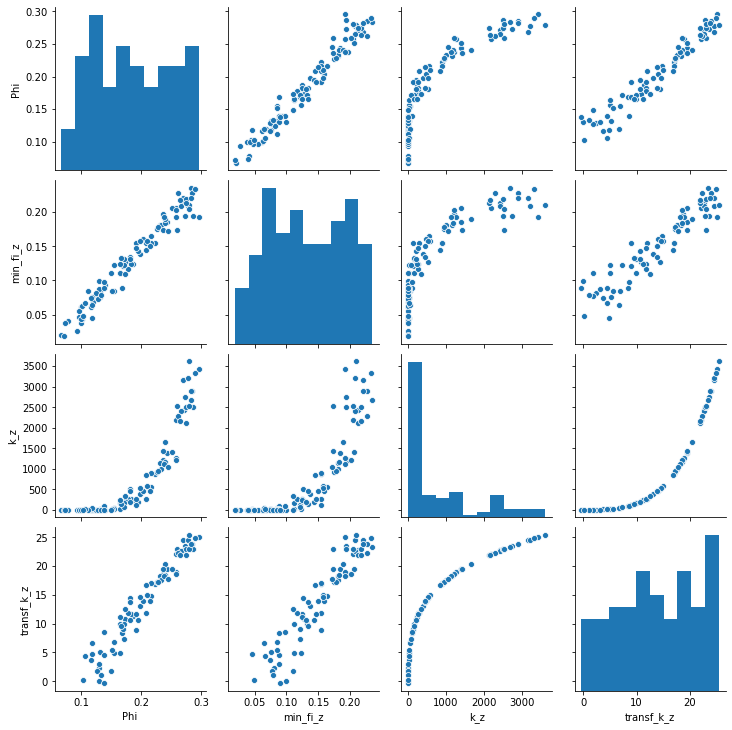

In [29]:
sns.pairplot(data[['Phi', 'min_fi_z', 'k_z', 'transf_k_z']])

Не сильно то это нам и помогло, среднее значение сильно коррелирет с $\Phi$ и не дает какой-то дополнительной информации. Посмотрим на значения дисперсии (std) профиля пористости.

In [30]:
std_fi_z = cut_por_profile.std(axis=1)

In [31]:
data['std_fi_z'] = std_fi_z

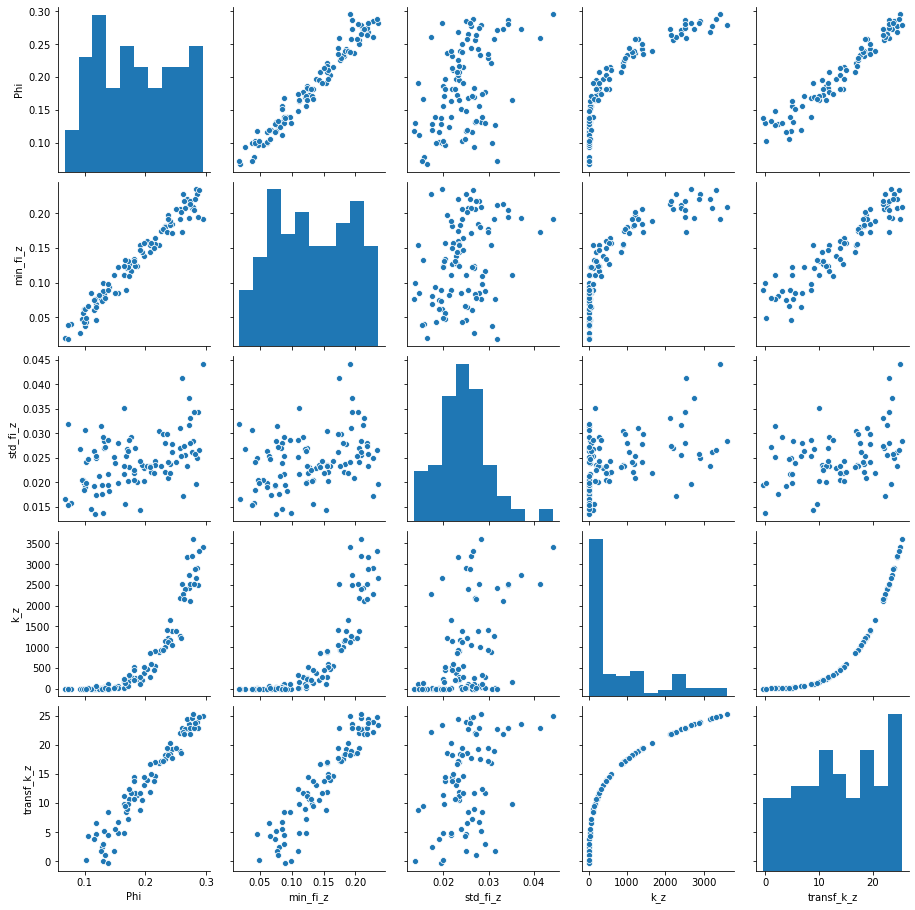

In [32]:
sns.pairplot(data[['Phi', 'min_fi_z', 'std_fi_z', 'k_z', 'transf_k_z']])

Std пока не дает никакой дополнительной информации.
В итоге у нас есть три сильно коррелированные с $k_z$ величины: $\Phi$, mean_fi_z, min_fi_z.
Так как эти три величины несут одну у туже информацию, оставим среди них только $\Phi$. 

Посмотрим на распределение локальной пористости первого образца:

Text(0.5, 0, 'fi_z')

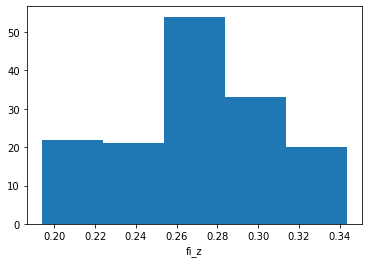

In [37]:
plt.hist(cut_por_profile[0], bins=5)
plt.xlabel('fi_z')

Чтобы достать какие-то дополнительные данные из профилей образцов, мы можем разбить каждое распределение на 5 секций (как на диаграмме выше) и получить распределение пористости для каждого образца. 
Сделать мы сможем это с помощью следующей функции:

In [52]:
def create_profile(orig_profile, bins=10, min_v=None, max_v=None):
    N = len(orig_profile[0])
    if min_v is None or max_v is None:
        min_v = np.min(orig_profile)
        max_v = np.max(orig_profile)
        
    edges = np.linspace(min_v, max_v*1.001, bins+1)
    
    new_profile = np.zeros((len(orig_profile), bins))
    
    for i in range(len(edges)-1):
        for j, string in enumerate(orig_profile):
            for element in string:
                if edges[i] <= element < edges[i+1]:
                    new_profile[j, i] += 1
    
    return new_profile / N
      

Посмотрим еще на тестовую выборку:

In [44]:
test_porosity = pd.read_csv('test_porosity.csv', header=None, comment='#')
test_porosityProfile=pd.read_csv('test_porosityProfile.csv', header=None, comment='#').to_numpy()[:, 25:175]

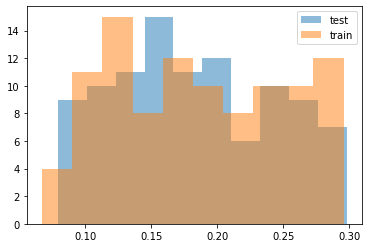

In [47]:
plt.hist(test_porosity, label='test', alpha=0.5)
plt.hist(porosity, label='train', alpha=0.5)
plt.legend()
plt.show()

Распределения похожи друг на друга, что хорошо

# Преобразование данных

In [40]:
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Для создания распределения профиля пористости нам нужно знать минимальное и максимальное значение локальной пористости среди двух выборок

In [50]:
min_pr = np.min([np.min(test_porosityProfile), np.min(cut_por_profile)])
max_pr = np.max([np.max(test_porosityProfile), np.max(cut_por_profile)])

In [51]:
min_pr, max_pr

(0.018525, 0.392275)

In [56]:
new_profile = create_profile(cut_por_profile, 5, min_pr, max_pr)

In [57]:
new_profile[0]

array([0.        , 0.        , 0.23333333, 0.64      , 0.12666667])

# Классификация

Сначала обучим классификатор находить образцы с нулевым значением проницаемости $k_z$

In [71]:
X = np.hstack((data.Phi.to_numpy().reshape(-1, 1), new_profile))
y = data.k_z.apply(lambda x: 0 if x==0 else 1)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Сбалансируем классы для предсказания пород с нулевой проницаемостью

In [73]:
blnc_X = np.vstack((X_train[y_train==0],X_train[y_train==0],X_train[y_train==0], X_train[y_train==0], X_train[y_train==1]))
blnc_y = np.hstack((y_train[y_train==0],y_train[y_train==0],y_train[y_train==0], y_train[y_train==0], y_train[y_train==1]))

In [74]:
blnc_X, blnc_y = shuffle(blnc_X, blnc_y)

Дляклассификаци будет использовать рандомный лес, так как у нас очень малое объектов, нужно не допустить, чтобы лес просто запомнил тренировочную выборку и переобучился

In [75]:
rfc = RandomForestClassifier()

In [76]:
grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [2, 3, 4, 5]
    
}

In [77]:
gr_search = GridSearchCV(rfc, param_grid=grid, n_jobs=-1)
gr_search.fit(blnc_X, blnc_y)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'n_estimators': [400, 500, 600]})

In [78]:
gr_search.best_score_

0.9541310541310543

In [79]:
gr_search.best_params_

{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 400}

In [80]:
best_rf = gr_search.best_estimator_

In [81]:
accuracy_score(best_rf.predict(X_test), y_test)

0.85

In [82]:
print(list(y_test))
print(list(best_rf.predict(X_test)))

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]


Обучим теперь лучший классификатор на всей выборке:

In [84]:
full_blnc_X = np.vstack((X[y==0], X[y==0], X[y==0], X[y==0], X[y==1]))
full_blnc_y = np.hstack((y[y==0],y[y==0],y[y==0], y[y==0], y[y==1]))

In [85]:
best_rf.fit(full_blnc_X, full_blnc_y)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=400)

In [88]:
accuracy_score(best_rf.predict(X), y)

0.96

# Регрессия

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Теперь натренируем регрессор на тех значениях, которые не равны нулю. 

Возьмем колонки transf_k_z и наш профиль пропускания в качестве признаков у образцов 

In [171]:
reg_X = X[y > 0]
reg_y = data.transf_k_z.dropna()

In [172]:
reg_X.shape, reg_y.shape

((80, 6), (80,))

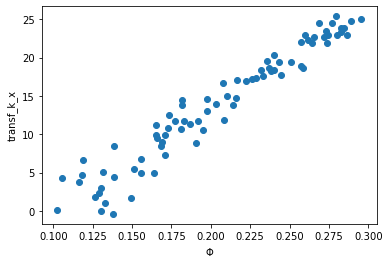

In [173]:
plt.scatter(reg_X[:,0], reg_y)
plt.xlabel('$\Phi$')
plt.ylabel('transf_k_x')
plt.show()

Сделаем линейное преобразование для признаков $\Phi$ и transf_k_x

In [174]:
min_k_z = reg_y.min()
max_k_z = reg_y.max()

min_Phi = reg_X[:,0].min()
max_Phi = reg_X[:,0].max()

In [175]:
reg_y = (reg_y - min_k_z) / (max_k_z-min_k_z)
reg_X[:,0] = (reg_X[:,0] - min_Phi) / (max_Phi - min_Phi)

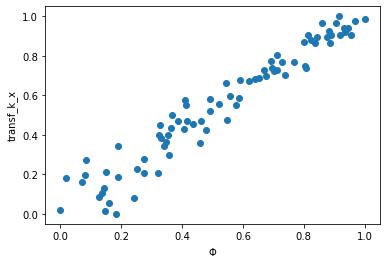

In [176]:
plt.scatter(reg_X[:,0], reg_y)
plt.xlabel('$\Phi$')
plt.ylabel('transf_k_x')
plt.show()

In [177]:
reg_X = np.hstack([reg_X, (reg_X[:,0]**2).reshape(-1, 1)])

In [178]:
lr = LinearRegression()
lr.fit(reg_X, reg_y)
mean_squared_error(lr.predict(reg_X), reg_y)

0.004757690314757779

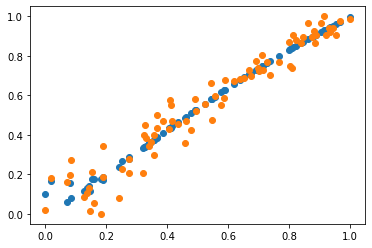

In [179]:
plt.scatter(reg_X[:,0], lr.predict(reg_X))
plt.scatter(reg_X[:,0], reg_y)

In [180]:
lr.coef_

array([ 1.40895918,  0.29217917, -0.06918452, -0.07763808, -0.07352802,
       -0.07182856, -0.32747166])

# Test data

In [151]:
from sklearn.metrics import mean_absolute_error

Напишем функцию, которая делает точно такие же преобразование с тестовыми данными, потом делает обратное преобразование и возвращает результат

In [184]:
def make_pred(porosity, porosityProfile, regressor, slassifier, min_pr, max_pr, lmbda):
    new_profile = create_profile(porosityProfile, 5, min_pr, max_pr)
    X = np.hstack((porosity.reshape(-1, 1), new_profile))
    y = slassifier.predict(X)
    
    test_data = pd.DataFrame(data=X)
    test_data['k_z'] = y
    reg_X = test_data[test_data.k_z != 0].to_numpy()[:, :-1]
    reg_X[:,0] = (reg_X[:,0] - min_Phi) / (max_Phi - min_Phi)
    reg_X = np.hstack([reg_X, (reg_X[:,0]**2).reshape(-1, 1)])    
    

    reg_y = lr.predict(reg_X)
    reg_y = reg_y * (max_k_z-min_k_z) + min_k_z
    reg_y = invboxcox(reg_y, lmbda)
    
    test_data.loc[test_data.k_z != 0, 'k_z'] = reg_y
    
    
    return test_data.k_z.to_numpy()

In [185]:
train_results = make_pred(porosity.Phi.to_numpy(), cut_por_profile, lr, best_rf, min_pr, max_pr, lmbda)

In [186]:
mean_absolute_error(train_results, data['k_z'].to_numpy())

123.5705798457931

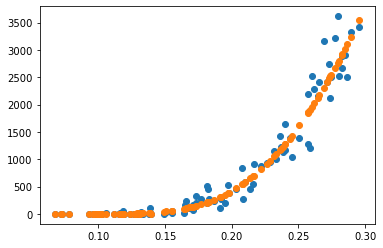

In [187]:
plt.scatter(data.Phi, data['k_z'])
plt.scatter(data.Phi, train_results)

Еще раз загрузим тестовые данные для надежности:

In [189]:
test_porosity = pd.read_csv('test_porosity.csv', header=None, comment='#')
test_porosityProfile=pd.read_csv('test_porosityProfile.csv', header=None, comment='#').to_numpy()[:, 25:175]

In [190]:
test_results = make_pred(test_porosity.to_numpy(), test_porosityProfile, lr, best_rf, min_pr, max_pr, lmbda)

In [197]:
test_results[:5]

array([  94.59901455, 2154.58640082, 1682.2694693 ,  292.90154444,
          0.        ])

In [198]:
len(test_results)

100

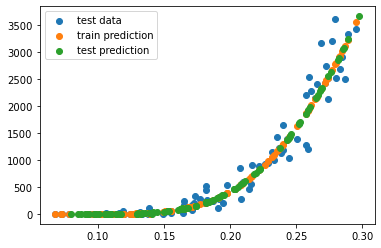

In [195]:
plt.scatter(data.Phi, data['k_z'], label='test data')
plt.scatter(data.Phi, train_results, label = 'train prediction')
plt.scatter(test_porosity, test_results, label = 'test prediction')
plt.legend()
plt.show()

Выглядит адекватно

Сохраним данные в файл:

In [196]:
np.savetxt('simplePrediction_permeabilityZ.csv', test_results, 
           header='абсолютная проницаемость вдоль оси Z (мД)',delimiter=",", encoding='utf8')